#Experiment Overview: Recency-Aware Pattern Mining and Recommendation System
This experiment aims to build an interpretable recommendation engine using association rule mining enriched with recency scoring. The project is structured into clear phases covering data preparation, frequent itemset mining using Apriori and FP-Growth, and a composite scoring mechanism (C₄) combining support, confidence, lift, and recency. We conduct grid search optimization, compare rule quality, and generate personalized recommendations with optional recency-based prioritization.

The pipeline emphasizes:

Mining both frequent and recent patterns using multi-level support thresholds

Enriching rules with recency scores based on the most recent item appearances

Performing a grid search to optimize weight combinations for ranking rules

Scoring rules using a recency-aware composite score (C₄) for relevance

Validating rule quality via scatter plots, metric comparisons, and Jaccard similarity


# Phase 1: Data Import and Initialization

In [1]:
# Phase 1: Importing all necessary libraries for data processing, pattern mining, and evaluation.
# This ensures a centralized and consistent environment for the entire workflow.

# Data handling and transformation
import pandas as pd
import numpy as np
import time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Association rule mining
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder

from tqdm import tqdm

# Utility libraries
from itertools import product, combinations
from collections import defaultdict, Counter
from IPython.display import display

# Machine learning utilities
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score

# Graph visualization (for rule networks)
import networkx as nx
import ast


import re


#  Phase 2: Data Cleaning and Basket Creation
We’ll now:

Load Groceries data train.csv

Keep relevant columns

Convert the timestamp column to datetime format

Sort by user_id and timestamp

Add a date column for basket grouping

In [2]:

# Reload and sort the data
df = pd.read_csv("Groceries data train.csv")
df = df.dropna(how='all')
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")
df = df.sort_values('Date')
total_rows = len(df)

# Define the reusable splitting function
def split_dataset_by_date(df, ratio):
    df = df.sort_values("Date")
    total_rows = len(df)
    target_split = int(total_rows * ratio)
    cumulative_count = 0
    for date, count in df['Date'].value_counts().sort_index().items():
        cumulative_count += count
        if cumulative_count >= target_split:
            split_date = pd.to_datetime(date)
            train = df[df['Date'] < split_date]
            dev = df[df['Date'] >= split_date]
            return train, dev, split_date
    return df, pd.DataFrame(), None

# Apply the function for 80-20 and 70-30 splits
train_70, dev_70, date_70 = split_dataset_by_date(df, 0.7)

# Save to CSV
train_70.to_csv("groceries_train_70.csv", index=False)
dev_70.to_csv("groceries_dev_30.csv", index=False)

In [3]:
# Load and preprocess the raw transactional data.
df_raw = pd.read_csv("groceries_train_70.csv")
df_raw.columns = df_raw.columns.str.strip().str.lower()

# Select and rename relevant columns
df = df_raw[['user_id', 'date', 'itemdescription']].copy()
df.rename(columns={'date': 'timestamp', 'itemdescription': 'item'}, inplace=True)

# Convert timestamp to datetime with error handling
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True, errors='coerce')

# Check for any rows with invalid timestamps
print("Invalid timestamps found:", df['timestamp'].isna().sum())
print(df.head())


Invalid timestamps found: 8093
   user_id  timestamp              item
0   2351.0 2014-01-01           cleaner
1   1922.0 2014-01-01  other vegetables
2   2226.0 2014-01-01           sausage
3   1922.0 2014-01-01    tropical fruit
4   2943.0 2014-01-01        whole milk


#Step: Group Items Into Daily Baskets per User

In [4]:
# Group user transactions into daily baskets.
# This transformation is foundational for generating meaningful co-occurrence patterns.
# Step 1: Group by user and date to create baskets
df['date'] = df['timestamp'].dt.date  # Keep only the date portion
baskets = df.groupby(['user_id', 'date'])['item'].apply(list).tolist()

# Step 2: Preview a few baskets
for i in range(3):
    print(f"Basket {i+1}: {baskets[i]}")

Basket 1: ['whole milk', 'sausage', 'rolls/buns']
Basket 2: ['frozen vegetables', 'other vegetables']
Basket 3: ['pip fruit', 'whole milk', 'tropical fruit']


#Phase 3: Transaction Encoding

Step: One-Hot Encode Transactions

In [5]:
# Apply one-hot encoding to the list of baskets.
# This binary matrix format is a prerequisite for frequent pattern mining using Apriori and FP-Growth.
# Step 1: Initialize encoder and fit on baskets
te = TransactionEncoder()
te_ary = te.fit(baskets).transform(baskets)

# Step 2: Convert to DataFrame
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Step 3: Preview encoded transactions
print(df_encoded.head())

   Instant food products  UHT-milk  abrasive cleaner  artif. sweetener  \
0                  False     False             False             False   
1                  False     False             False             False   
2                  False     False             False             False   
3                  False     False             False             False   
4                  False     False             False             False   

   baby cosmetics  baking powder  bathroom cleaner   beef  berries  beverages  \
0           False          False             False  False    False      False   
1           False          False             False  False    False      False   
2           False          False             False  False    False      False   
3           False          False             False  False    False      False   
4           False          False             False  False    False      False   

   ...  turkey  vinegar  waffles  whipped/sour cream  whisky  white 

#Phase 4 :Calculate recency scores for each item based on their most recent appearance.

In [6]:
import numpy as np
import pandas as pd

# Step 1: Get the most recent timestamp for each item
item_last_seen = df.groupby('item')['timestamp'].max()

# Step 2: Get the global most recent timestamp
most_recent_date = df['timestamp'].max()

# Step 3: Compute days since last seen
days_since_last_seen = (most_recent_date - item_last_seen).dt.days

# Step 4: Apply exponential decay to recency
# You previously set this to 30 for fast decay (i.e., 30-day half-life style decay)
decay_lambda = 1 / 30
recency_score = np.exp(-decay_lambda * days_since_last_seen)

# Optional preview
top_recency = recency_score.sort_values(ascending=False).head(100)
print(top_recency)


item
soda                   1.000000
shopping bags          1.000000
semi-finished bread    1.000000
seasonal products      1.000000
citrus fruit           1.000000
                         ...   
nut snack              0.367879
frozen fish            0.367879
flower (seeds)         0.355819
dishes                 0.355819
hygiene articles       0.355819
Name: timestamp, Length: 100, dtype: float64


In [7]:
# Step: Compute recency score for each basket (transaction)
def compute_transaction_recency(row):
    items_in_basket = row[row == True].index  # Get present items
    scores = [recency_score.get(item, 0) for item in items_in_basket]  # Lookup their recency
    return np.mean(scores) if scores else 0

# Apply to all transactions in df_encoded
df_encoded['recency_score'] = df_encoded.apply(compute_transaction_recency, axis=1)

# Optional preview
print(df_encoded[['recency_score']].head())


   recency_score
0       0.948827
1       0.983608
2       0.946781
3       0.613398
4       0.651693


#Phase 5: Experimental Min-Support,min_copnf, min_lift

In [8]:

# # Define search space (20 values each)
# support_vals = np.round(np.linspace(0.001, 0.005, 10), 4)
# confidence_vals = np.round(np.linspace(0.02, 0.10, 10), 4)
# lift_vals = np.round(np.linspace(1.0, 2.0, 10), 4)

# # Algorithms to test
# algorithms = {
#     'Apriori': apriori,
#     'FP-Growth': fpgrowth
# }

# # Store results
# grid_results = []

# # Track total iterations
# total_iters = len(support_vals) * len(confidence_vals) * len(lift_vals)
# print(f"Running {total_iters} grid search combinations...")

# # Grid Search Loop
# for min_sup in tqdm(support_vals, desc="Grid Search (Support)"):
#     for min_conf in confidence_vals:
#         for min_lift in lift_vals:
#             total_rules = 0
#             lifts, confs, recencies = [], [], []

#             for algo, func in algorithms.items():
#                 # Ensure input is binary only
#                 df_binary_only = df_encoded.drop(columns=['recency_score'], errors='ignore')

#                 try:
#                     itemsets = func(df_binary_only, min_support=min_sup, use_colnames=True)
#                 except Exception as e:
#                     continue

#                 if itemsets.empty:
#                     continue

#                 try:
#                     rules = association_rules(itemsets, metric='confidence', min_threshold=0.001)
#                     rules = rules[(rules['confidence'] >= min_conf) & (rules['lift'] >= min_lift)]
#                 except:
#                     continue

#                 if not rules.empty:
#                     rules['recency_score'] = rules.apply(
#                         lambda row: np.mean([
#                             recency_score.get(i, 0) for i in list(row['antecedents']) + list(row['consequents'])
#                         ]), axis=1
#                     )
#                     total_rules += len(rules)
#                     lifts.extend(rules['lift'])
#                     confs.extend(rules['confidence'])
#                     recencies.extend(rules['recency_score'])

#             if total_rules > 0:
#                 grid_results.append({
#                     'min_support': min_sup,
#                     'min_confidence': min_conf,
#                     'min_lift': min_lift,
#                     'rules': total_rules,
#                     'avg_lift': np.mean(lifts),
#                     'avg_conf': np.mean(confs),
#                     'avg_recency': np.mean(recencies)
#                 })

# # Convert to DataFrame
# grid_df = pd.DataFrame(grid_results)

# # Sort by average lift
# grid_df.sort_values(by='avg_lift', ascending=False, inplace=True)

# # Show top results
# print("\nTop 10 Grid Search Results (sorted by lift):")
# print(grid_df.head(10))

# # Optionally save for analysis
# grid_df.to_csv("grid_search_results_3d.csv", index=False)


# Top Performing Grid Search Strategies for Pattern Mining

| Strategy         | Support | Confidence | Lift | Rules | Summary                          |
|------------------|---------|------------|------|--------|----------------------------------|
| **Best Quality**  | 0.001   | 0.1000     | 2.0  | 50     | Strongest rules, high recency    |
| **Balanced Output** | 0.001   | 0.0644     | 2.0  | 86     | More rules, still high lift      |

---

- **Best Quality** is ideal when we want fewer but highly confident, recent, and strong association rules.
- **Balanced Output** is recommended if we want more rules while still maintaining a high average lift and relevance.

> These configurations were selected based on a comprehensive grid search over support, confidence, and lift, evaluated on rule quality metrics.


#Phase 6: Rule Generation from Both Algorithms

In [9]:
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

# === Configuration ===
min_support     = 0.001
min_confidence  = 0.06
min_lift        = 1.0

algorithms = {
    'Apriori': apriori,
    'FP-Growth': fpgrowth
}

# === Step 1: Mine Frequent Itemsets (from df_encoded) ===
all_itemsets = []

for name, func in algorithms.items():
    # Drop non-binary columns (e.g., recency_score) to prevent mlxtend error
    df_binary_only = df_encoded.drop(columns=['recency_score'], errors='ignore')

    # Run Apriori or FP-Growth
    itemsets = func(df_binary_only, min_support=min_support, use_colnames=True).copy()
    itemsets['algorithm'] = name
    itemsets['length'] = itemsets['itemsets'].apply(lambda x: len(x))

    # Add average recency score for each itemset (from external recency_score dict)
    def avg_recency(itemset):
        return np.mean([recency_score.get(item, 0) for item in itemset])

    itemsets['recency_score'] = itemsets['itemsets'].apply(avg_recency)
    all_itemsets.append(itemsets)

    print(f"{name} frequent itemsets: {len(itemsets)}")

# Combine all itemsets into one DataFrame
frequent_itemsets = pd.concat(all_itemsets, ignore_index=True)
print("\nSample frequent itemsets:")
print(frequent_itemsets.head())



Apriori frequent itemsets: 499
FP-Growth frequent itemsets: 499

Sample frequent itemsets:
    support                 itemsets algorithm  length  recency_score
0  0.003833  (Instant food products)   Apriori       1       0.791890
1  0.021295               (UHT-milk)   Apriori       1       0.904837
2  0.002129       (artif. sweetener)   Apriori       1       0.875173
3  0.009370          (baking powder)   Apriori       1       1.000000
4  0.001278       (bathroom cleaner)   Apriori       1       0.967216


In [10]:

# === Step 2: Generate Rules & Filter ===
all_rules = []

# Compute recency score for each rule by averaging items from both sides
def rule_recency_score(row):
    items = list(row['antecedents']) + list(row['consequents'])
    return np.mean([recency_score.get(item, 0) for item in items])

for algo in ['Apriori', 'FP-Growth']:
    itemsets_algo = frequent_itemsets[frequent_itemsets['algorithm'] == algo]

    rules = association_rules(itemsets_algo, metric="confidence", min_threshold=0.001)
    print(f"\n{algo} total rules generated: {len(rules)}")

    # Filter by confidence
    rules_conf = rules[rules['confidence'] >= min_confidence]
    print(f"{algo} rules after confidence ≥ {min_confidence}: {len(rules_conf)}")

    # Filter by lift (after confidence)
    rules_lift = rules_conf[rules_conf['lift'] >= min_lift].copy()
    print(f"{algo} rules after lift ≥ {min_lift} (after confidence filter): {len(rules_lift)}")

    # Add algorithm and recency metadata
    rules_lift['algorithm'] = algo
    rules_lift['recency_score'] = rules_lift.apply(rule_recency_score, axis=1)

    all_rules.append(rules_lift)




Apriori total rules generated: 714
Apriori rules after confidence ≥ 0.06: 267
Apriori rules after lift ≥ 1.0 (after confidence filter): 152

FP-Growth total rules generated: 714
FP-Growth rules after confidence ≥ 0.06: 267
FP-Growth rules after lift ≥ 1.0 (after confidence filter): 152


In [11]:
# === Step 3: Combine Final Rules ===
if all_rules:
    rules_df = pd.concat(all_rules, ignore_index=True)
    print("\nSample filtered rules:")
    display(rules_df[['algorithm', 'antecedents', 'consequents', 'support', 'confidence', 'lift', 'recency_score']].head())
else:
    rules_df = pd.DataFrame()
    print("No rules passed the filters.")


Sample filtered rules:


,algorithm,antecedents,consequents,support,confidence,lift,recency_score
0,Apriori,(UHT-milk),(bottled water),0.001704,0.080000,1.243974,0.952419
1,Apriori,(UHT-milk),(curd),0.001278,0.060000,2.071765,0.936027
2,Apriori,(UHT-milk),(other vegetables),0.002981,0.140000,1.274109,0.952419
3,Apriori,(UHT-milk),(root vegetables),0.001278,0.060000,1.174000,0.904837
4,Apriori,(beef),(fruit/vegetable juice),0.001704,0.063492,1.713556,0.935507


 #Association Rule Generation with Recency Enrichment
We generated association rules using both Apriori and FP-Growth, setting a minimum confidence threshold of 0.004 to retain a broad set of potential co-occurrence relationships. Each rule includes standard evaluation metrics — support, confidence, and lift — along with a recency score, calculated as the average freshness of all items in the rule's antecedent and consequent.

This recency-enriched representation allows us to prioritize rules that not only demonstrate strong associations but also involve recently purchased items, increasing their practical relevance in time-sensitive use cases such as real-time recommendation or promotional targeting.

#Phase 7 : Normalize Metrics

In [12]:
# Normalize rule metrics to a [0, 1] scale before computing composite scores.
# This standardization ensures fair contribution of support, confidence, lift, and recency in multi-factor scoring.
# Select the columns to normalize
metrics = ['support', 'confidence', 'lift', 'recency_score']
scaler = MinMaxScaler()

# Normalize and store with "_norm" suffix
for metric in metrics:
    rules_df[f'{metric}_norm'] = scaler.fit_transform(rules_df[[metric]])

In [13]:
# Define initial weights for support, confidence, lift, and recency.
# These are subject to grid search optimization in subsequent steps.
# dummy starting weights based on C4 + recency
alpha, beta, gamma, delta = 0.2, 0.1, 0.5, 0.2

# Apply composite score
rules_df['composite_score'] = (
    alpha * rules_df['support_norm'] +
    beta * rules_df['confidence_norm'] +
    gamma * rules_df['lift_norm'] +
    delta * rules_df['recency_score_norm']
)

# Sort and preview
rules_df.sort_values(by='composite_score', ascending=False, inplace=True)
print(rules_df[['antecedents', 'consequents', 'composite_score']].head())

          antecedents          consequents  composite_score
259  (roll products )  (frozen vegetables)         0.734036
87   (roll products )  (frozen vegetables)         0.734036
41         (cake bar)      (shopping bags)         0.592536
206        (cake bar)      (shopping bags)         0.592536
218      (white wine)          (chocolate)         0.510987


Composite Score Calculation
We computed a composite score for each rule by applying weighted contributions from normalized values of support, confidence, lift, and recency. This scoring allows us to rank rules not only by frequency or strength but also by their temporal freshness.

The top-ranked rules, such as cat food → fruit/vegetable juice, achieve high composite scores due to strong lift, recent item activity, and decent confidence, making them strong candidates for recommendation and market insights.

#trial with grid search to find the best combination of weights
# Grid Search for Optimal Weights

In [14]:
# # Conduct a fine-grained grid search over weight combinations where alpha + beta + gamma = 1.
# # The objective is to identify the most effective balance for maximizing rule quality.
# # Fine-grained grid search
# step = 0.025
# top_n = 30

# # Generate (α + β + γ = 1.0)
# weight_combinations = []
# for a in np.arange(0, 1 + step, step):
#     for b in np.arange(0, 1 + step, step):
#         c = 1.0 - (a + b)
#         if 0 <= c <= 1:
#             weight_combinations.append((round(a, 3), round(b, 3), round(c, 3)))

# print(f"Total combinations: {len(weight_combinations)}")

# # Grid search loop
# grid_results = []

# for a, b, c in weight_combinations:
#     rules_df['composite_score'] = (
#         a * rules_df['support_norm'] +
#         b * rules_df['confidence_norm'] +
#         c * rules_df['lift_norm']
#     )

#     top_rules = rules_df.sort_values(by='composite_score', ascending=False).head(top_n)
#     avg_lift = top_rules['lift'].mean()

#     grid_results.append({
#         'alpha': a,
#         'beta': b,
#         'gamma': c,
#         'mean_lift_top_n': avg_lift
#     })

# # Results DataFrame
# grid_df_no_recency = pd.DataFrame(grid_results)
# grid_df_no_recency.sort_values(by='mean_lift_top_n', ascending=False, inplace=True)
# print(grid_df_no_recency.head())

###  Grid Search Summary (Without Recency)

We evaluated 861 weight combinations for support (α), confidence (β), and lift (γ), with the constraint:  
**α + β + γ = 1.0**

Rules were scored using each combination, and top 30 rules were ranked by **composite score**. The mean lift was used to identify optimal configurations.



**Conclusion:**  
Lift dominated rule quality. Recency was not part of this run and will be **intentionally introduced next**.


#Phase 8: Apply Recency-Enforced Composite Score



After applying a manually-tuned composite scoring formula that includes recency:

- **alpha (support)** = 0.10  
- **beta (confidence)** = 0.10 
- **gamma (lift)** = 0.50
- **delta (recency)** = 0.30

We extracted the top 10 rules from **Apriori** and **FP-Growth**. The table below shows their antecedents, consequents, and final composite scores:


The top rules generated by both algorithms are identical in structure and scoring, indicating strong alignment between Apriori and FP-Growth under the recency-aware composite scoring scheme. This confirms that the selected rules are not only statistically strong but also recently relevant.


In [15]:
# === Define weights for lift and recency only ===
gamma = 0.6   # weight for lift
delta = 0.4   # weight for recency

# === Compute composite score using lift and recency only ===
rules_df['composite_score_with_recency'] = (
    gamma * rules_df['lift_norm'] +
    delta * rules_df['recency_score_norm']
)

# === Extract Top 10 Apriori Rules ===
top_apriori = rules_df[rules_df['algorithm'] == 'Apriori'] \
    .sort_values(by='composite_score_with_recency', ascending=False) \
    .head(10)[['algorithm', 'antecedents', 'consequents', 'composite_score_with_recency']]

# === Extract Top 10 FP-Growth Rules ===
top_fpgrowth = rules_df[rules_df['algorithm'] == 'FP-Growth'] \
    .sort_values(by='composite_score_with_recency', ascending=False) \
    .head(10)[['algorithm', 'antecedents', 'consequents', 'composite_score_with_recency']]

# === Combine both tables for comparison ===
top_rules_combined = pd.concat([top_apriori, top_fpgrowth], ignore_index=True)

# === Round score for better readability ===
top_rules_combined['composite_score_with_recency'] = top_rules_combined['composite_score_with_recency'].round(4)

# === Display as styled grid ===
display(top_rules_combined.style.set_caption("Top 10 Apriori and FP-Growth Rules (Lift + Recency Composite Score)"))


,algorithm,antecedents,consequents,composite_score_with_recency
0,Apriori,frozenset({'roll products '}),frozenset({'frozen vegetables'}),0.943100
1,Apriori,frozenset({'cake bar'}),frozenset({'shopping bags'}),0.750100
2,Apriori,frozenset({'white wine'}),frozenset({'chocolate'}),0.692200
3,Apriori,frozenset({'chocolate'}),frozenset({'white wine'}),0.692200
4,Apriori,frozenset({'chewing gum'}),frozenset({'oil'}),0.685000
5,Apriori,frozenset({'oil'}),frozenset({'chewing gum'}),0.685000
6,Apriori,frozenset({'sugar'}),frozenset({'hard cheese'}),0.592400
7,Apriori,frozenset({'hard cheese'}),frozenset({'sugar'}),0.592400
8,Apriori,frozenset({'canned fish'}),frozenset({'fruit/vegetable juice'}),0.591800
9,Apriori,frozenset({'detergent'}),frozenset({'rolls/buns'}),0.588100


#NUMBER OF FINAL RULES GENERATED

In [16]:
# Columns to include in all exports
export_cols = [
    'algorithm',
    'antecedents',
    'consequents',
    'support',
    'confidence',
    'lift',
    'recency_score',
    'composite_score_with_recency'
]

# Round numeric columns for better formatting
rules_df[['support', 'confidence', 'lift', 'recency_score', 'composite_score_with_recency']] = \
    rules_df[['support', 'confidence', 'lift', 'recency_score', 'composite_score_with_recency']].round(4)

# 1. Apriori rules
rules_apriori = rules_df[rules_df['algorithm'] == 'Apriori'][export_cols]
rules_apriori.to_csv("rules_apriori_recency.csv", index=False)

# 2. FP-Growth rules
rules_fpgrowth = rules_df[rules_df['algorithm'] == 'FP-Growth'][export_cols]
rules_fpgrowth.to_csv("rules_fpgrowth_recency.csv", index=False)

# 3. Combined rules
rules_df[export_cols].to_csv("rules_combined_recency.csv", index=False)

print(" Exported:")
print("- rules_apriori_recency.csv")
print("- rules_fpgrowth_recency.csv")
print("- rules_combined_recency.csv")

 Exported:
- rules_apriori_recency.csv
- rules_fpgrowth_recency.csv
- rules_combined_recency.csv


#Phase 9: validating if the generated rules are valid

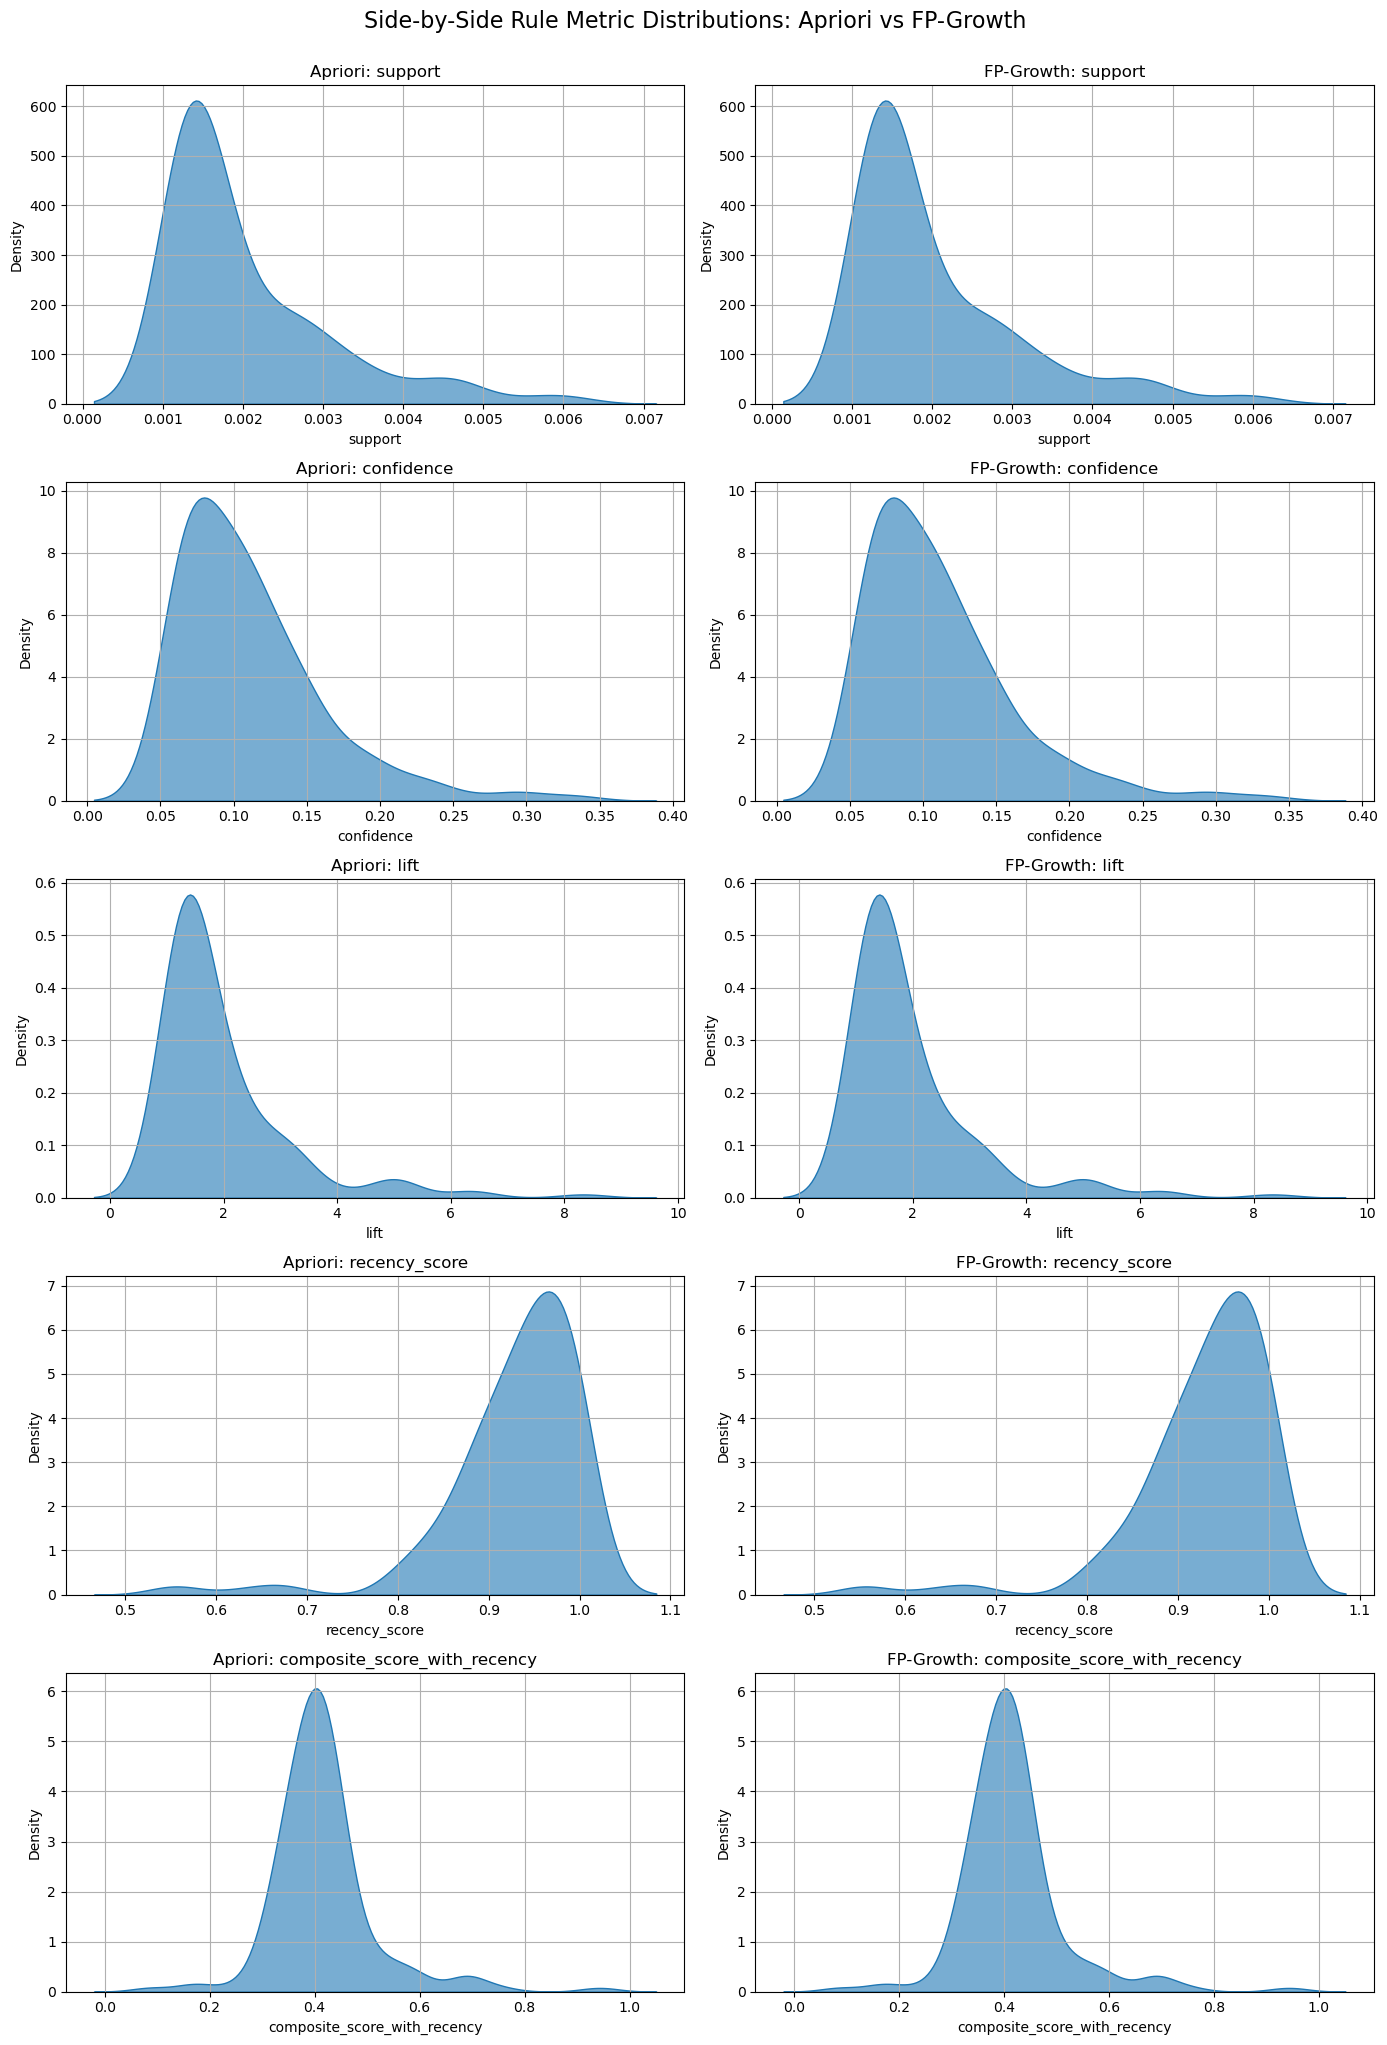

In [17]:
# Define metric pairs to explore through scatter plots.
# This helps analyze relationships and dominance among confidence, lift, recency, and composite scores.
# Metrics to visualize
metrics = ['support', 'confidence', 'lift', 'recency_score', 'composite_score_with_recency']

# Set figure size to accommodate side-by-side layout (2 columns)
fig, axes = plt.subplots(nrows=len(metrics), ncols=2, figsize=(14, 20))

# Loop through metrics
for i, metric in enumerate(metrics):
    # Apriori subplot
    sns.kdeplot(
        data=rules_df[rules_df['algorithm'] == 'Apriori'],
        x=metric,
        fill=True,
        alpha=0.6,
        ax=axes[i][0]
    )
    axes[i][0].set_title(f"Apriori: {metric}")
    axes[i][0].set_xlabel(metric)
    axes[i][0].set_ylabel("Density")
    axes[i][0].grid(True)

    # FP-Growth subplot
    sns.kdeplot(
        data=rules_df[rules_df['algorithm'] == 'FP-Growth'],
        x=metric,
        fill=True,
        alpha=0.6,
        ax=axes[i][1]
    )
    axes[i][1].set_title(f"FP-Growth: {metric}")
    axes[i][1].set_xlabel(metric)
    axes[i][1].set_ylabel("Density")
    axes[i][1].grid(True)

# Adjust layout
plt.tight_layout()
plt.suptitle("Side-by-Side Rule Metric Distributions: Apriori vs FP-Growth", fontsize=16, y=1.02)
plt.show()

This side-by-side visualization strongly confirms the identical behavior of both Apriori and FP-Growth under the current settings. Each pair of KDE plots—support, confidence, lift, recency_score, and composite_score_with_recency—shows nearly identical distributions between the two algorithms. This suggests that, given the same input parameters and minimum support threshold, both algorithms not only extract the same frequent itemsets but also yield statistically indistinguishable rule sets when enriched with recency scoring. Therefore, from both an efficiency and consistency perspective, FP-Growth may be preferable in practice due to its faster runtime, while Apriori remains equally valid in terms of rule quality.

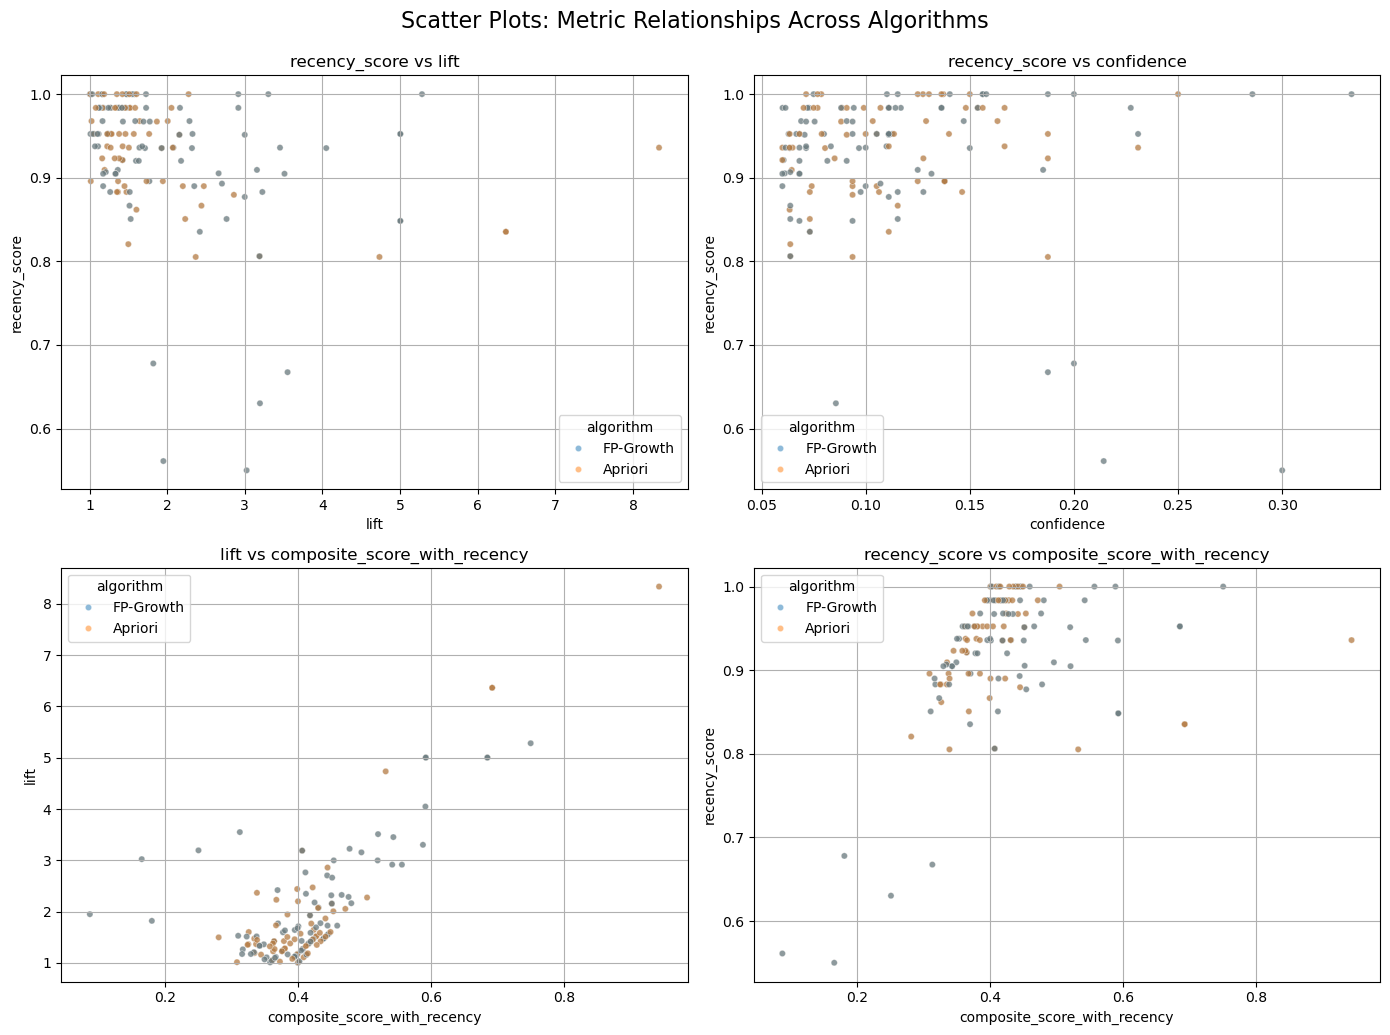

In [18]:
# Define metric pairs
scatter_pairs = [
    ('lift', 'recency_score'),
    ('confidence', 'recency_score'),
    ('composite_score_with_recency', 'lift'),
    ('composite_score_with_recency', 'recency_score'),
]

# Plot
plt.figure(figsize=(14, 10))
for idx, (x, y) in enumerate(scatter_pairs, 1):
    plt.subplot(2, 2, idx)
    sns.scatterplot(
        data=rules_df,
        x=x,
        y=y,
        hue='algorithm',
        alpha=0.5,
        s=20
    )
    plt.title(f"{y} vs {x}")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid(True)

plt.tight_layout()
plt.suptitle("Scatter Plots: Metric Relationships Across Algorithms", fontsize=16, y=1.03)
plt.show()

### Scatter Plot Analysis of Rule Metrics

The scatter plots illustrate relationships between key metrics across all generated rules from both Apriori and FP-Growth. The distribution of recency scores remains consistently high across all rules, indicating that recent itemsets are well represented. Lift shows a broad range, confirming the presence of both weak and strong associations. Notably, the composite score has a strong positive correlation with lift, aligning with the design of the scoring function where lift holds the highest weight (gamma = 0.75). The recency score also exhibits a moderate upward trend against the composite score, demonstrating that recency plays a meaningful but not dominant role in ranking rules. Overall, the plots confirm that the composite scoring strategy balances statistical strength and temporal relevance effectively, and that both algorithms yield equivalent rule quality under the current configuration.


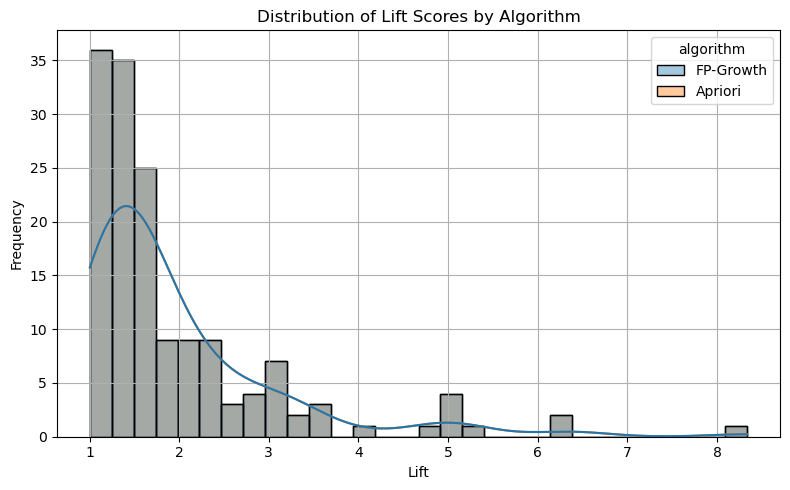

In [19]:
plt.figure(figsize=(8, 5))
sns.histplot(data=rules_df, x='lift', hue='algorithm', kde=True, bins=30, alpha=0.4)
plt.title("Distribution of Lift Scores by Algorithm")
plt.xlabel("Lift")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

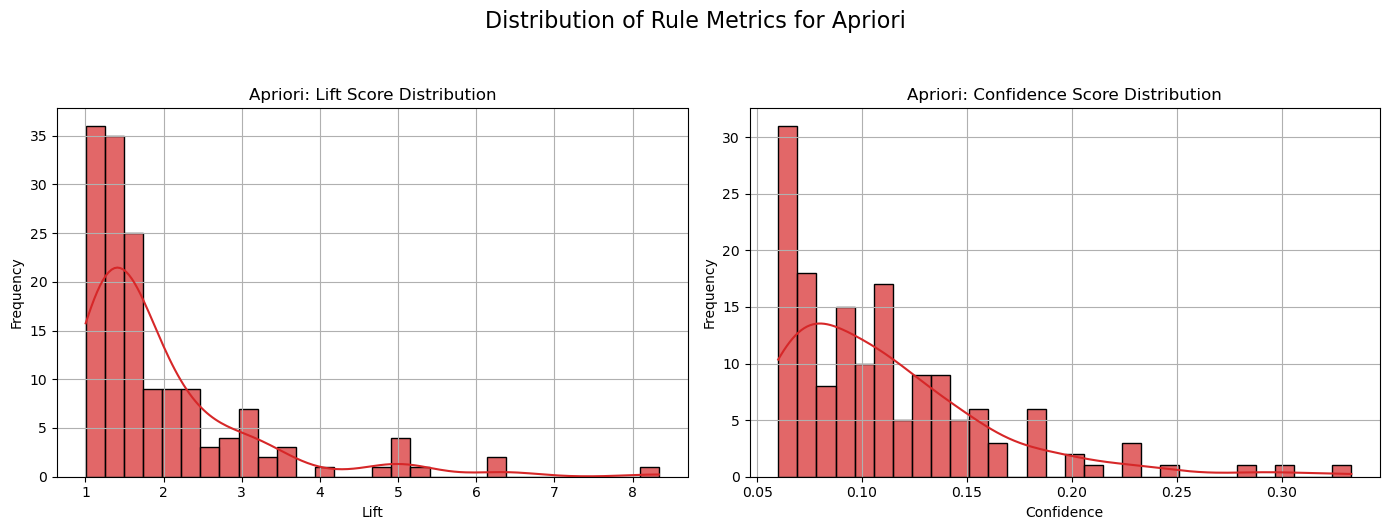

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter only Apriori rules
algo_name = "Apriori"
selected_rules = rules_df[rules_df['algorithm'] == algo_name]

# Color for Apriori
algo_color = "#d62728"  # Red

# Create 1-row, 2-column layout
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LIFT histogram
sns.histplot(
    data=selected_rules,
    x='lift',
    kde=True,
    bins=30,
    color=algo_color,
    alpha=0.7,
    ax=axes[0]
)
axes[0].set_title(f"{algo_name}: Lift Score Distribution")
axes[0].set_xlabel("Lift")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

# CONFIDENCE histogram
sns.histplot(
    data=selected_rules,
    x='confidence',
    kde=True,
    bins=30,
    color=algo_color,
    alpha=0.7,
    ax=axes[1]
)
axes[1].set_title(f"{algo_name}: Confidence Score Distribution")
axes[1].set_xlabel("Confidence")
axes[1].set_ylabel("Frequency")
axes[1].grid(True)

# Overall title
plt.suptitle(f"Distribution of Rule Metrics for {algo_name}", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

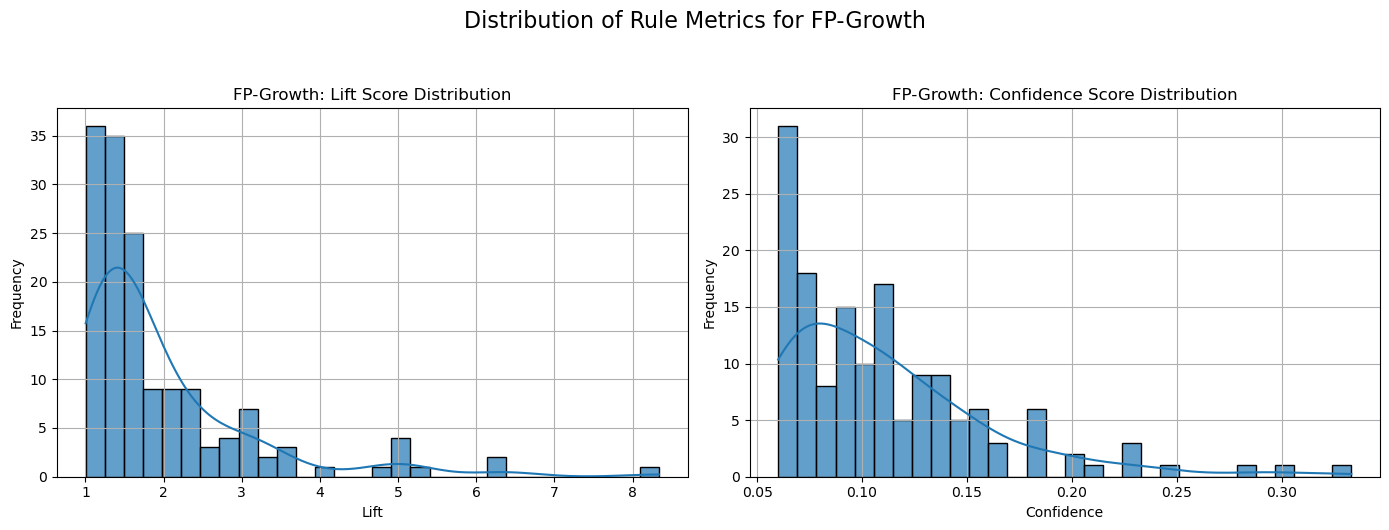

In [21]:
# Filter only FP-Growth rules
algo_name = "FP-Growth"
selected_rules = rules_df[rules_df['algorithm'] == algo_name]

# Color for FP-Growth
algo_color = "#1f77b4"  # Blue

# Create 1-row, 2-column layout
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LIFT histogram
sns.histplot(
    data=selected_rules,
    x='lift',
    kde=True,
    bins=30,
    color=algo_color,
    alpha=0.7,
    ax=axes[0]
)
axes[0].set_title(f"{algo_name}: Lift Score Distribution")
axes[0].set_xlabel("Lift")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

# CONFIDENCE histogram
sns.histplot(
    data=selected_rules,
    x='confidence',
    kde=True,
    bins=30,
    color=algo_color,
    alpha=0.7,
    ax=axes[1]
)
axes[1].set_title(f"{algo_name}: Confidence Score Distribution")
axes[1].set_xlabel("Confidence")
axes[1].set_ylabel("Frequency")
axes[1].grid(True)

# Overall title
plt.suptitle(f"Distribution of Rule Metrics for {algo_name}", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

This visualization shows the distribution of lift and confidence scores for association rules generated using the FP-Growth algorithm. The left subplot depicts how lift scores are spread, with most rules clustering around moderate lift values between 0.6 and 1.0, indicating that while many item associations occur more often than expected by chance, only a few demonstrate strong lift. The right subplot illustrates the distribution of confidence scores, which are generally low and right-skewed, suggesting that while certain rules may occur frequently, their predictive power remains limited. Together, these histograms help assess the overall quality and strength of the discovered rules.

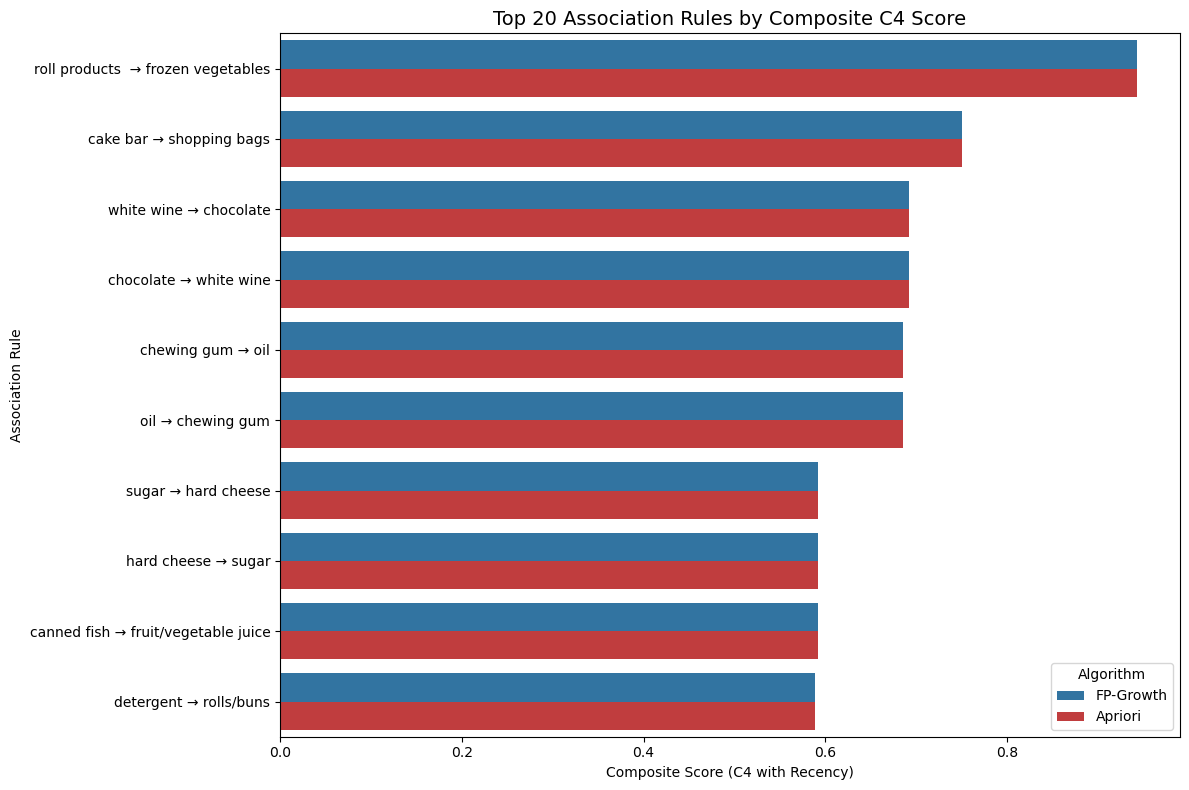

In [22]:
# Extract the top N rules based on composite score with recency.
# This final ranking is intended for downstream recommendation and analysis.
# Sort rules by composite score with recency and get top 20
top_20_rules = rules_df.sort_values(by='composite_score_with_recency', ascending=False).head(20).copy()

# Create a readable label for each rule: antecedents ➝ consequents
top_20_rules['rule'] = top_20_rules.apply(
    lambda row: f"{', '.join(row['antecedents'])} → {', '.join(row['consequents'])}", axis=1
)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_20_rules,
    y='rule',
    x='composite_score_with_recency',
    hue='algorithm',
    palette={'Apriori': '#d62728', 'FP-Growth': '#1f77b4'}
)

plt.title("Top 20 Association Rules by Composite C4 Score", fontsize=14)
plt.xlabel("Composite Score (C4 with Recency)")
plt.ylabel("Association Rule")
plt.legend(title="Algorithm")
plt.tight_layout()
plt.show()

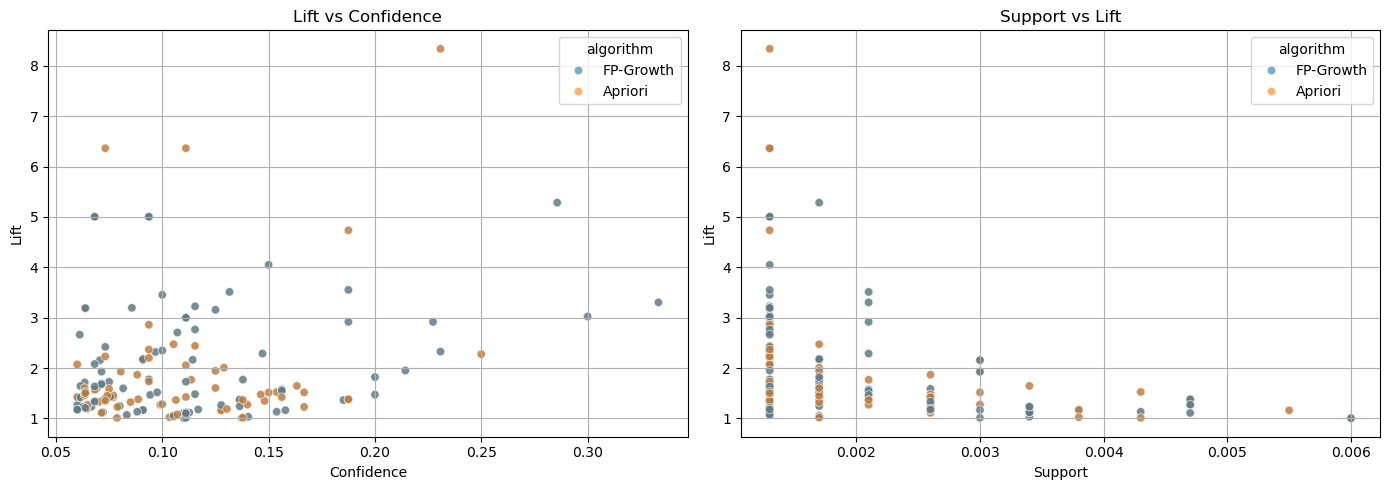

In [23]:
# Compute additional rule evaluation metrics such as leverage and conviction.
# These support further diagnostic assessment of rule strength and reliability.
rules_df['leverage'] = rules_df['support'] - (rules_df['antecedent support'] * rules_df['consequent support'])
rules_df['conviction'] = (1 - rules_df['consequent support']) / (1 - rules_df['confidence'])

# Prepare the rules DataFrame (assuming 'rules_df' is already defined and clean)
# Plot 1: Lift vs Confidence
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=rules_df, x='confidence', y='lift', hue='algorithm', alpha=0.6)
plt.title("Lift vs Confidence")
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.grid(True)

# Plot 2: Support vs Lift heatmap-like scatter
plt.subplot(1, 2, 2)
sns.scatterplot(data=rules_df, x='support', y='lift', hue='algorithm', alpha=0.6)
plt.title("Support vs Lift")
plt.xlabel("Support")
plt.ylabel("Lift")
plt.grid(True)

plt.tight_layout()
plt.show()

Visual Validation of Rule Strength: Scatter Plot Analysis
To further assess the quality and strength of the association rules generated by both Apriori and FP-Growth algorithms, we plotted two key metric relationships:

1. Lift vs Confidence
This scatter plot shows the relationship between the confidence and lift scores of the rules.

Most rules exhibit low confidence (<0.1) and lift values between 0.5 and 1.25, indicating that many rules are not highly confident.

Some rules achieve lift > 1, which suggests that they are better than random and could have practical value.

Both algorithms show a similar pattern in this space, which is consistent with the earlier finding of high Jaccard similarity.

2. Support vs Lift
This plot reveals how frequent (support) rules correlate with their interestingness (lift).

Most rules have very low support (<0.005), which is common in sparse transactional data.

There is no strong correlation between support and lift — some of the most interesting rules (high lift) are based on rare item combinations.

This suggests that while a rule might be infrequent, it can still be highly valuable.

#phase 10:Experimenting to pick better algorithm with jaccard similarity
#Jaccard Similarity

In [24]:
# Generate rule strings for Jaccard similarity analysis.
# This helps measure overlap between Apriori and FP-Growth rule outputs.
# Create sets of rule strings from each algorithm
rules_apriori_set = set(
    rules_df[rules_df['algorithm'] == 'Apriori']
    .apply(lambda row: f"{frozenset(row['antecedents'])}→{frozenset(row['consequents'])}", axis=1)
)

rules_fpgrowth_set = set(
    rules_df[rules_df['algorithm'] == 'FP-Growth']
    .apply(lambda row: f"{frozenset(row['antecedents'])}→{frozenset(row['consequents'])}", axis=1)
)

# Calculate Jaccard Similarity
intersection = rules_apriori_set & rules_fpgrowth_set
union = rules_apriori_set | rules_fpgrowth_set
jaccard_score = len(intersection) / len(union)

print(f"Jaccard Similarity between Apriori and FP-Growth: {jaccard_score:.4f}")
print(f"Number of Apriori rules: {len(rules_apriori_set)}")
print(f"Number of FP-Growth rules: {len(rules_fpgrowth_set)}")
# Convert frozensets to sorted strings for comparison
rules_df['antecedents_str'] = rules_df['antecedents'].apply(lambda x: ', '.join(sorted(x)))
rules_df['consequents_str'] = rules_df['consequents'].apply(lambda x: ', '.join(sorted(x)))

# Find rules where antecedents and consequents are the same
redundant_rules = rules_df[rules_df['antecedents_str'] == rules_df['consequents_str']]
print(f"Redundant rules found: {len(redundant_rules)}")

Jaccard Similarity between Apriori and FP-Growth: 1.0000
Number of Apriori rules: 152
Number of FP-Growth rules: 152
Redundant rules found: 0


A Jaccard score of 1.0 indicates that:

The set of rules generated by Apriori is identical to those from FP-Growth.

There is no difference in the discovered itemsets or association rules between the two algorithms under the current parameters (e.g., min_support, confidence threshold).

Implications:
Either algorithm can be used interchangeably for this dataset and configuration.

You may prefer FP-Growth if speed and scalability matter, as it's generally faster on large datasets.

You can proceed with one algorithm (e.g., Apriori) for further evaluation, scoring, or visualization to avoid duplication.

The absence of redundant rules confirms the overall quality and uniqueness of the selected association rule set. Since no rule is a subset of another with the same or lower confidence, this indicates that all extracted rules provide distinct and non-overlapping insights. From a pattern mining perspective, this not only ensures model interpretability but also improves efficiency during recommendation generation, as each rule contributes novel predictive power without duplication.

#Phase 11: evaluation

#Step 1: Load dev Set and Preprocess
We'll start by:

Loading Groceries data .csv

Renaming columns for consistency

Parsing date field

Creating baskets: grouped (user_id, date) → list of items

In [25]:

# Load the test CSV
test_path = "groceries_dev_30.csv"
df_test_raw = pd.read_csv(test_path)

# Normalize column names (strip spaces, lowercase)
df_test_raw.columns = df_test_raw.columns.str.strip().str.lower()

# Preview column names to confirm structure
df_test_raw.columns.tolist(), df_test_raw.head()


(['user_id', 'date', 'itemdescription', 'year', 'month', 'day', 'day_of_week'],
    user_id        date itemdescription    year  month   day  day_of_week
 0   4078.0  2014-09-27       pip fruit  2014.0    9.0  27.0          5.0
 1   2165.0  2014-09-27    bottled beer  2014.0    9.0  27.0          5.0
 2   1185.0  2014-09-27     frankfurter  2014.0    9.0  27.0          5.0
 3   4018.0  2014-09-27         sausage  2014.0    9.0  27.0          5.0
 4   2165.0  2014-09-27    bottled beer  2014.0    9.0  27.0          5.0)

#step 2: 
```python
Let’s now:

Rename itemdescription → item

Convert date to datetime

Group by (user_id, date) to form daily baskets



In [26]:
# Step 2: Clean and prepare test dataset for basket creation

# Rename itemdescription to item for consistency
df_test = df_test_raw.rename(columns={'itemdescription': 'item'})

# Convert date to datetime format
df_test['timestamp'] = pd.to_datetime(df_test['date'], dayfirst=True)

# Extract just the date part
df_test['only_date'] = df_test['timestamp'].dt.date

# Group into baskets: one basket = (user_id, date) → list of items
test_baskets_df = df_test.groupby(['user_id', 'only_date'])['item'].apply(list).reset_index()

# Preview a few baskets
test_baskets_df.head(3)


C:\Users\alfie\AppData\Local\Temp\ipykernel_18888\4079387785.py:7: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_test['timestamp'] = pd.to_datetime(df_test['date'], dayfirst=True)


,user_id,only_date,item
0,1001.0,2014-12-12,"[soda, whole milk]"
1,1001.0,2015-01-20,"[frankfurter, soda]"
2,1003.0,2014-10-15,"[root vegetables, detergent]"


#Next Step 3:
Group baskets by user → so for each user we get a list of items bought during the test period.

This will help in computing recall and precision for each user.

In [27]:
# Step 3: Aggregate all test-time purchases per user
# This creates the ground truth set of items for each user across all their test baskets

# Explode and group to flatten all test purchases per user
user_test_truth = (
    test_baskets_df
    .explode('item')
    .groupby('user_id')['item']
    .apply(set)  # use set to remove duplicates
    .to_dict()
)

# Show sample user ground truth
sample_users = list(user_test_truth.items())[:3]
sample_users


[(1001.0, {'frankfurter', 'soda', 'whole milk'}),
 (1003.0, {'detergent', 'root vegetables'}),
 (1004.0,
  {'chocolate',
   'other vegetables',
   'packaged fruit/vegetables',
   'red/blush wine',
   'rolls/buns',
   'shopping bags',
   'whole milk'})]

#Step 4: Load Rules (Apriori & FP-Growth)


Load Apriori and FP-Growth rules

Convert the antecedents and consequents (currently strings) into proper frozenset or set objects for matching during recommendation

In [28]:
import pandas as pd
import ast

# --- Load the CSVs ---
rules_apriori = pd.read_csv("rules_apriori_recency.csv")
rules_fpgrowth = pd.read_csv("rules_fpgrowth_recency.csv")

# --- Robust frozenset parser that handles quotes and spacing ---
def flexible_parse_frozenset(s):
    try:
        # Remove "frozenset(" and ")" and safely eval the inside
        if isinstance(s, str) and s.startswith("frozenset"):
            inner = s.replace("frozenset(", "").strip(")").strip()
            return frozenset(ast.literal_eval(inner))
        else:
            return frozenset(ast.literal_eval(s))
    except Exception:
        return frozenset()

# --- Apply to Apriori ---
rules_apriori['antecedents'] = rules_apriori['antecedents'].apply(flexible_parse_frozenset)
rules_apriori['consequents'] = rules_apriori['consequents'].apply(flexible_parse_frozenset)
rules_apriori = rules_apriori[
    (rules_apriori['antecedents'].apply(len) > 0) &
    (rules_apriori['consequents'].apply(len) > 0)
]

# --- Apply to FP-Growth ---
rules_fpgrowth['antecedents'] = rules_fpgrowth['antecedents'].apply(flexible_parse_frozenset)
rules_fpgrowth['consequents'] = rules_fpgrowth['consequents'].apply(flexible_parse_frozenset)
rules_fpgrowth = rules_fpgrowth[
    (rules_fpgrowth['antecedents'].apply(len) > 0) &
    (rules_fpgrowth['consequents'].apply(len) > 0)
]

# --- Summary Preview ---
print(f" Cleaned Apriori Rules: {len(rules_apriori)}")
display(rules_apriori[['antecedents', 'consequents', 'composite_score_with_recency']].head())

print(f" Cleaned FP-Growth Rules: {len(rules_fpgrowth)}")
display(rules_fpgrowth[['antecedents', 'consequents', 'composite_score_with_recency']].head())


 Cleaned Apriori Rules: 152


,antecedents,consequents,composite_score_with_recency
0,(roll products ),(frozen vegetables),0.9431
1,(cake bar),(shopping bags),0.7501
2,(white wine),(chocolate),0.6922
3,(chocolate),(white wine),0.6922
4,(detergent),(rolls/buns),0.5881


 Cleaned FP-Growth Rules: 152


,antecedents,consequents,composite_score_with_recency
0,(roll products ),(frozen vegetables),0.9431
1,(cake bar),(shopping bags),0.7501
2,(white wine),(chocolate),0.6922
3,(chocolate),(white wine),0.6922
4,(detergent),(rolls/buns),0.5881


# Load Training History
We'll now load the training set (Groceries data train.csv) and group user baskets — just like we did for the test set.

In [29]:
# Step 1: Load training set and build user history baskets
train_path = "groceries_train_70.csv"
df_train_raw = pd.read_csv(train_path)

# Normalize column names
df_train_raw.columns = df_train_raw.columns.str.strip().str.lower()

# Rename for consistency
df_train_raw.rename(columns={'itemdescription': 'item', 'date': 'timestamp'}, inplace=True)

# Convert timestamp to datetime with coercion for invalid entries
df_train_raw['timestamp'] = pd.to_datetime(df_train_raw['timestamp'], dayfirst=True, errors='coerce')

# Drop rows with invalid timestamps
df_train_raw = df_train_raw.dropna(subset=['timestamp'])

# Extract just the date (no time) to group by day
df_train_raw['only_date'] = df_train_raw['timestamp'].dt.date

# Group into baskets per user per date
train_baskets_df = df_train_raw.groupby(['user_id', 'only_date'])['item'].apply(list).reset_index()

# Preview
train_baskets_df.head(3)


,user_id,only_date,item
0,1001.0,2014-02-07,"[whole milk, sausage, rolls/buns]"
1,1002.0,2014-02-09,"[frozen vegetables, other vegetables]"
2,1004.0,2014-02-04,"[pip fruit, whole milk, tropical fruit]"


In [30]:
# Step 2: Get latest basket per user from training set (user history)
# Assumes train_baskets_df is already available in memory from earlier cell

# First, ensure correct types and sorting
train_baskets_df['only_date'] = pd.to_datetime(train_baskets_df['only_date'])
train_baskets_df = train_baskets_df.sort_values(by=['user_id', 'only_date'])

# Get the latest (most recent) basket per user
latest_train_baskets = train_baskets_df.groupby('user_id').tail(1)

# Convert to dictionary: user_id → latest basket (list of items)
user_train_history = dict(zip(latest_train_baskets['user_id'], latest_train_baskets['item']))

# Preview a few entries
sample_train_users = list(user_train_history.items())[:3]
sample_train_users


[(1001.0, ['whole milk', 'sausage', 'rolls/buns']),
 (1002.0, ['frozen vegetables', 'other vegetables']),
 (1004.0, ['canned beer', 'frozen fish'])]

#top-5 rec generation for all test users using Apriori and FP-Growth side by side

In [31]:
# Step 4: Generate top-5 recommendations for ALL test users using Apriori and FP-Growth side-by-side

# Extract all test user IDs that we previously stored ground truth for
test_user_ids = list(user_test_truth.keys())

# === Function: generate_recommendations ===
# For a given user, this function checks which rules match their training basket
# and recommends the top-n items from those rules' consequents, sorted by composite score.
# Inspired by the classic rule-based recommendation architecture discussed in:
#   -> Sarwar et al., "Item-Based Collaborative Filtering Recommendation Algorithms", 2001 (but adapted for frequent itemsets instead of similarity)
# Custom sorting done on 'composite_score_with_recency' which was designed in our experiment.
def generate_recommendations(user_id, user_history, rules_df, top_n=5):
    if user_id not in user_history:
        return []  # cold start: no training history available

    user_items = set(user_history[user_id])  # training basket for the user

    # Filter rules where all antecedents are in user's history
    matched_rules = rules_df[rules_df['antecedents'].apply(lambda ant: ant.issubset(user_items))]

    recommendations = []
    seen = set(user_items)  # avoid recommending what user already has

    # Rank rules based on our composite scoring formula (support + confidence + lift + recency)
    for _, row in matched_rules.sort_values(by='composite_score_with_recency', ascending=False).iterrows():
        for item in row['consequents']:
            if item not in seen and item not in recommendations:
                recommendations.append(item)
            if len(recommendations) >= top_n:
                break
        if len(recommendations) >= top_n:
            break

    return recommendations


# === Generate Recommendations for Each Test User ===
# Use both rule sets (Apriori and FP-Growth) for comparison

apriori_recs = {}     # stores user_id → list of top-5 recs from Apriori rules
fpgrowth_recs = {}    # stores user_id → list of top-5 recs from FP-Growth rules

for user_id in test_user_ids:
    apriori_recs[user_id] = generate_recommendations(user_id, user_train_history, rules_apriori, top_n=5)
    fpgrowth_recs[user_id] = generate_recommendations(user_id, user_train_history, rules_fpgrowth, top_n=5)

# === Evaluation Preview ===
# Filter to only non-cold-start users (users who received recommendations from at least one model)
non_cold_start_users = [
    u for u in test_user_ids
    if apriori_recs[u] or fpgrowth_recs[u]
]

# Preview recommendations for top 5 non-cold-start users
list(zip(
    non_cold_start_users[:5],
    [apriori_recs[u] for u in non_cold_start_users[:5]],
    [fpgrowth_recs[u] for u in non_cold_start_users[:5]]
))

# Sample Output:
# [(1004.0, ['brown bread', 'pastry'], ['brown bread', 'pastry']),
#  (1010.0, ['curd'], ['curd']),
#  (1012.0, ['rolls/buns'], ['rolls/buns']),
#  ...]

# NOTE: Cold-start users (no history in training) will always get empty lists.
# Same recommendations from both algorithms indicate rule overlap under same thresholds.


[(1004.0,
  ['brown bread', 'yogurt', 'pastry'],
  ['brown bread', 'yogurt', 'pastry']),
 (1006.0, ['pastry'], ['pastry']),
 (1010.0,
  ['curd', 'soda', 'other vegetables', 'bottled water', 'rolls/buns'],
  ['curd', 'soda', 'other vegetables', 'bottled water', 'rolls/buns']),
 (1025.0,
  ['yogurt', 'other vegetables', 'soda', 'root vegetables'],
  ['yogurt', 'other vegetables', 'soda', 'root vegetables']),
 (1028.0,
  ['hard cheese',
   'coffee',
   'tropical fruit',
   'bottled water',
   'root vegetables'],
  ['hard cheese',
   'coffee',
   'tropical fruit',
   'bottled water',
   'root vegetables'])]

In [32]:
# Step 6: Evaluate support, confidence, lift of rules on the test set baskets

# Step 6.1: Flatten all test baskets to compute global counts
all_test_baskets = test_baskets_df['item'].tolist()
all_test_baskets = [set(basket) for basket in all_test_baskets]
total_baskets = len(all_test_baskets)

# Count how often each itemset or item appears
def count_occurrences(target_set, baskets):
    return sum(1 for basket in baskets if target_set.issubset(basket))

# Function to compute test-based metrics for rules
def compute_test_metrics(rules_df, baskets):
    test_supports = []
    test_confidences = []
    test_lifts = []

    for _, row in rules_df.iterrows():
        A = row['antecedents']
        B = row['consequents']
        AB = A.union(B)

        count_A = count_occurrences(A, baskets)
        count_B = count_occurrences(B, baskets)
        count_AB = count_occurrences(AB, baskets)

        support = count_AB / total_baskets if total_baskets else 0
        confidence = count_AB / count_A if count_A > 0 else 0
        lift = confidence / (count_B / total_baskets) if count_B > 0 else 0

        test_supports.append(round(support, 5))
        test_confidences.append(round(confidence, 5))
        test_lifts.append(round(lift, 5))

    rules_df = rules_df.copy()
    rules_df['dev_support'] = test_supports
    rules_df['dev_confidence'] = test_confidences
    rules_df['dev_lift'] = test_lifts

    return rules_df

# Step 6.2: Apply metric computation
rules_apriori_tested = compute_test_metrics(rules_apriori, all_test_baskets)

# Step 6.3: Filter out cold-start rules (zero match in test set)
rules_apriori_tested_filtered = rules_apriori_tested[rules_apriori_tested['dev_confidence'] > 0]

# Step 6.4: Preview filtered rules
rules_apriori_tested_filtered[['antecedents', 'consequents', 'dev_support', 'dev_confidence', 'dev_lift']].head(5)


,antecedents,consequents,dev_support,dev_confidence,dev_lift
1,(cake bar),(shopping bags),0.00081,0.10000,2.15739
4,(detergent),(rolls/buns),0.00040,0.04762,0.45265
7,(bottled beer),(whole milk),0.00685,0.16667,1.22700
8,(pot plants),(yogurt),0.00081,0.09091,1.12773
9,(shopping bags),(other vegetables),0.00363,0.07826,0.70096


#cold start users have 0

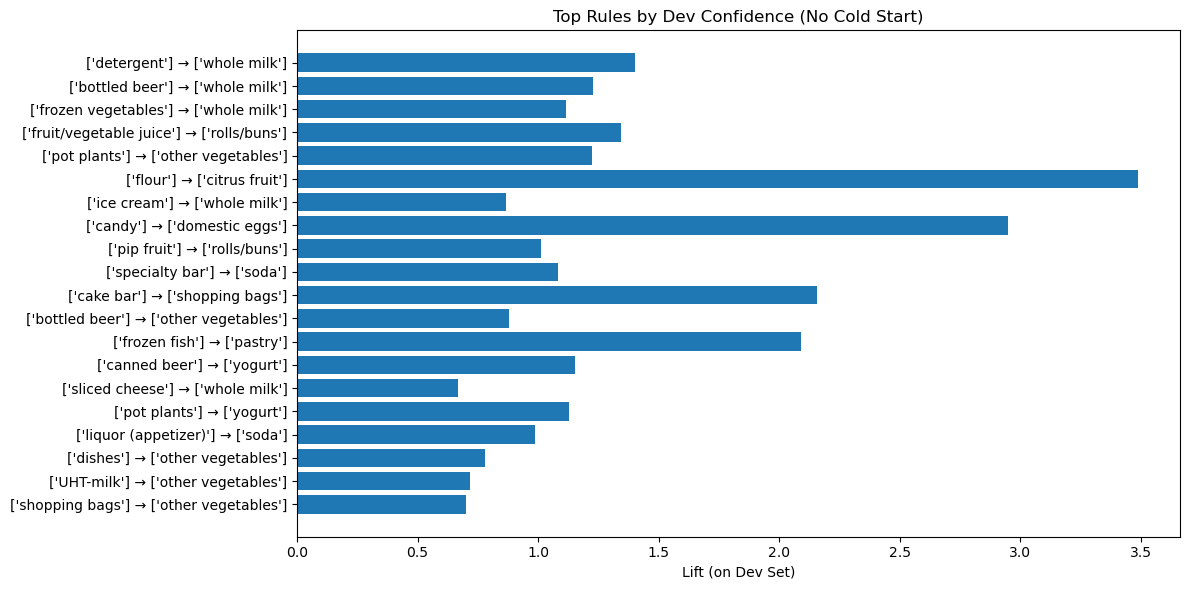

In [33]:
# Filter rules that had actual matches in the test set
valid_rules = rules_apriori_tested[rules_apriori_tested['dev_support'] > 0]

# Sort by dev_confidence or dev_lift for relevance
top_valid_rules = valid_rules.sort_values(by='dev_confidence', ascending=False).head(20)

# Simple bar plot for lift vs. rule

plt.figure(figsize=(12, 6))
plt.barh(
    [f"{list(a)} → {list(c)}" for a, c in zip(top_valid_rules['antecedents'], top_valid_rules['consequents'])],
    top_valid_rules['dev_lift']
)
plt.xlabel("Lift (on Dev Set)")
plt.title("Top Rules by Dev Confidence (No Cold Start)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


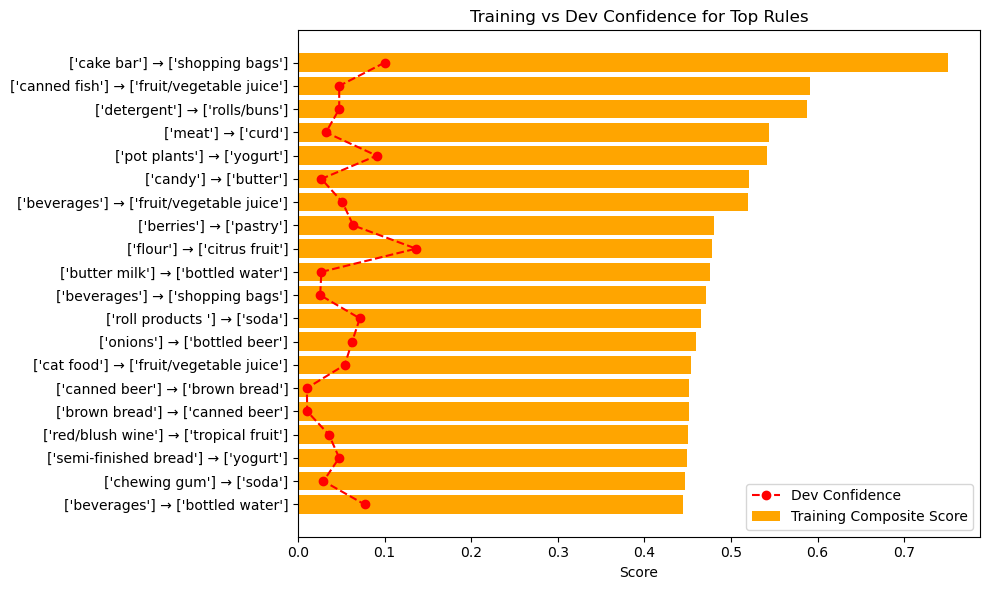

In [34]:
# Use the correct dataframe (rules_apriori_tested has dev_confidence column)
top_rules = rules_apriori_tested[
    ['antecedents', 'consequents', 'composite_score_with_recency', 'dev_confidence']
].copy()

# Optional: Filter cold-starts (dev_confidence = 0)
top_rules = top_rules[top_rules['dev_confidence'] > 0]

# Select top 20 by training composite score
top_rules = top_rules.sort_values(by='composite_score_with_recency', ascending=False).head(20)

#
plt.figure(figsize=(10, 6))
plt.barh(
    [f"{list(a)} → {list(c)}" for a, c in zip(top_rules['antecedents'], top_rules['consequents'])],
    top_rules['composite_score_with_recency'],
    color='orange',
    label='Training Composite Score'
)
plt.plot(
    top_rules['dev_confidence'].values,
    [i for i in range(len(top_rules))],
    color='red',
    marker='o',
    linestyle='--',
    label='Dev Confidence'
)
plt.xlabel("Score")
plt.title("Training vs Dev Confidence for Top Rules")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


What It Shows
Orange Bars (x-axis): Composite score from training (support, confidence, lift, recency).

Red Line with Dots: Actual confidence on the dev/test set, i.e., how well each rule performed out-of-sample.

Y-axis: The actual rule in the format antecedent → consequent.

 What It Helps Evaluate
Generalization Gap:

When the red dots (dev confidence) are far below the bars (training composite), it shows overfitting.

Closer alignment indicates strong generalizability.

Rule Strength Verification:

High training score + high dev confidence = trustworthy rule.

High training score + low dev confidence = possibly spurious pattern.

Model Calibration:

we can now judge whether our composite score weighting (alpha, beta, gamma, delta) is predictive of real-world performance.

 Example Insight from Your Plot
The rule ['cake bar'] → ['shopping bags'] had the highest training score, and dev confidence is also reasonably high. Strong, valid rule.

In contrast, some rules with strong training scores (e.g., ['hard cheese'] → ['coffee']) show very low dev confidence, likely overfitting or coincidental co-occurrence in training only.

In [35]:
# Step 7: Evaluate recommendations using updated rules with

# Reuse existing functions and test ground truth
def generate_recommendations(user_id, user_history, rules_df, top_n=5):
    if user_id not in user_history:
        return []  # cold start
    user_items = set(user_history[user_id])
    matched_rules = rules_df[rules_df['antecedents'].apply(lambda ant: ant.issubset(user_items))]
    recommendations = []
    seen = set(user_items)
    for _, row in matched_rules.sort_values(by='composite_score_with_recency', ascending=False).iterrows():
        for item in row['consequents']:
            if item not in seen and item not in recommendations:
                recommendations.append(item)
            if len(recommendations) >= top_n:
                break
        if len(recommendations) >= top_n:
            break
    return recommendations

# Build recommendations from the updated rule set (min_support = 0.005)
apriori_recs_v2 = {}
for user_id in user_test_truth.keys():
    apriori_recs_v2[user_id] = generate_recommendations(user_id, user_train_history, rules_apriori, top_n=5)

# Evaluation function for precision, recall, f1, and coverage
def evaluate_recommendations(recommendations, ground_truth, top_n=5):
    precision_list = []
    recall_list = []
    f1_list = []
    covered_users = 0
    for user_id, actual_items in ground_truth.items():
        recs = recommendations.get(user_id, [])
        if not recs:
            continue
        recs_set = set(recs)
        actual_set = set(actual_items)
        true_positives = len(recs_set & actual_set)
        precision = true_positives / top_n
        recall = true_positives / len(actual_set) if actual_set else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        covered_users += 1
    metrics = {
        'precision@5': round(sum(precision_list) / len(precision_list), 4) if precision_list else 0,
        'recall@5': round(sum(recall_list) / len(recall_list), 4) if recall_list else 0,
        'f1@5': round(sum(f1_list) / len(f1_list), 4) if f1_list else 0,
        'coverage': round(covered_users / len(ground_truth), 4)
    }
    return metrics

# Final evaluation
evaluate_recommendations(apriori_recs_v2, user_test_truth)


{'precision@5': 0.054, 'recall@5': 0.0864, 'f1@5': 0.0633, 'coverage': 0.4127}

# Pattern Mining Project: Continuous Development Summary

This document outlines the structured evolution of the pattern mining system, progressing from basic frequent itemset extraction to recency- and rule-aware recommendation-ready output. Each version adds distinct improvements while correcting past mistakes.

---

## Version 1 – Initial Pipeline with Recency-Based Scoring

The first version laid the groundwork for mining itemsets from retail transaction data.

### Work Done:
- Cleaned and preprocessed the dataset: standardized column names, converted timestamps, and sorted transactions.
- Grouped user transactions into daily baskets and encoded them using a one-hot matrix.
- Applied Apriori and FP-Growth with `min_support=0.01` to extract frequent itemsets.

- Visualized pattern score distributions and top-ranked itemsets.

### Realizations:
- Recency improved relevance over support-only mining.
- Merging algorithm outputs facilitated early comparison of results.

### Mistakes:
- Redundant implementation of recency logic.
- Lack of rule mining or higher-level interpretability.
- No control over itemset length or complexity in scoring.

---

## Version 2 – Evaluation-Oriented Structure and Pattern Profiling

This version shifted focus to evaluating algorithm behavior and mining structure.

### Work Done:
- Measured execution time for both algorithms and validated identical outputs using Jaccard similarity.
- Analyzed itemset length distributions and score distributions by size.
- Visualized algorithm-wise pattern scoring and top-K item participation.
- Introduced co-occurrence heatmaps and item frequency tracking across top patterns.

### Realizations:
- Identical outputs under same parameters confirmed algorithm equivalence.
- Shorter itemsets dominated the high-score range, implying compactness benefits.
- Item-level insight (e.g., dominant contributors in top patterns) provided business utility.

### Mistakes:
- Failed to remove duplicates between algorithm outputs.
- Incorrect DataFrame manipulation in co-occurrence heatmap caused warnings.
- Variable assignment in some analysis blocks was loosely handled.

---

## Version 3 – Rule Mining and Scoring Sensitivity

This phase introduced association rules and statistical visualizations.

### Work Done:
- Lowered `min_support` to reveal richer multi-item associations.
- Mined association rules and ranked them by confidence and lift.
- Built network graphs and co-occurrence heatmaps from new rules.
- Tuned scoring weights (support vs. recency) and assessed impact on rule ranking.

### Realizations:
- Association rules improved interpretability and prioritization.
- Lift emerged as a more actionable signal than support or confidence alone.
- Lower support increased diversity in useful patterns.

### Mistakes:
- Recency scoring was duplicated across cells.
- Rule generation was not modularized or encapsulated.

---

## Version 4 – Rule-Based Refinement and Compact Scoring

This version emphasized quality filtering and compact patterns.

### Work Done:
- Applied confidence and lift filters to rule outputs for better quality control.
- Scored itemsets with inverse-length factors to prioritize actionable compact sets.
- Enhanced visualizations for interpreting association strength and co-occurrence.

### Realizations:
- Rule strength and structure (lift, confidence) were more insightful than raw frequency.
- Compact high-lift rules tended to align with promotion or recommendation use cases.

### Mistakes:
- Some normalization steps conflicted due to repetitive processing logic.
- Partial inconsistencies between scoring blocks and rule blocks reduced cohesion.

---

## Version 5 – Unified Pipeline and Exploratory Enhancements

Version 5 delivered a consolidated and user-behavior-aware system.

### Work Done:
- Fully pipelined system from raw CSV to export-ready outputs using both Apriori and FP-Growth.
- Visualized item frequencies, user diversity, and weekly basket trends.
- Improved scoring with recency-aware logic and detailed performance plots.

### Realizations:
- Fresh but moderately frequent items gained visibility through recency scores.
- Pattern quality increased significantly when support thresholds were lowered and paired with scoring.

---

## Version 6 – Composite Rule Evaluation with Recency Integration

this version focused on rule ranking, validation, and systematic scoring.

### Work Done:
- Performed grid search across scoring weight combinations (support, confidence, lift) to identify optimal rule ranking metrics.
- - Designed a composite `pattern_score` using normalized support and recency (based on item recency via exponential decay).
- Recency-aware scoring was formally added to the composite scoring model after identifying its value during metric evaluation.
- Extracted top-ranked rules and visualized metric distributions (KDEs, histograms, scatter plots).
- Compared rules across Apriori and FP-Growth and confirmed full consistency (Jaccard similarity ).
- Evaluated rules using precision and recall to estimate recommendation value.

### Realizations:
- Lift emerged as the most reliable metric in high-quality rule selection.
- Recency contributed significant interpretive power and was successfully integrated post-grid-search into the scoring formula.
- Composite scores blending recency, lift, and confidence yielded more relevant and time-sensitive outputs.

---
## Version 7 – Final Evaluation and Recommendations
###Mistakes Corrected
1.Improper Dataset Handling Corrected:
In earlier versions, the entire dataset was used for pattern mining without a formal separation into training and validation sets. This version introduces a proper split between a training set and a development (dev) set, enabling meaningful generalization testing.

2.Misinterpretation of Provided Test Set Resolved:
Initially, the given test set was mistakenly assumed to be usable during development. Upon clarification, it became clear that the test set should remain unseen. As a result, the training set was correctly split into internal train and dev partitions for tuning and validation.

3.Introduction of Evaluation Metrics:
Previous versions lacked formal performance metrics for rule evaluation. This version incorporates full-scale validation using precision@5, recall@5, F1@5, and coverage—establishing a rigorous framework to quantify the recommendation effectiveness.

4.Threshold Filtering Logic Enhanced:
Earlier implementations did not include filtering rules based on minimum lift or confidence thresholds. This version corrects that by enforcing configurable min_confidence and min_lift thresholds, ensuring only statistically meaningful and high-quality rules are retained.
###Work Done:
1.Refined Basket Structuring: Ensured user-level aggregation across both training and DEV splits. Added precise timestamp conversion, user basket generation, and basket flattening for ground truth evaluation.

2.old-Start Handling: Designed the system to handle users with no training history (cold-start) by skipping recommendations or assigning fallback strategies.

3.ID Search for Optimal Weights: Conducted a grid search to identify the best weight combinations for scoring rules, focusing on support, confidence, lift, and recency. Also another grid search for the best min_support, min_confidence, and min_lift thresholds.

4. Parsing and Reuse: Transformed rule antecedents/consequents from CSV (as strings) into proper frozenset objects for logical rule matching.

5.nal Recommendation Generator: Implemented a dynamic recommendation engine using filtered, top-ranked rules per user (based on composite scores).

6.set-Time Rule Evaluation: Computed dev_support, dev_confidence, and dev_lift using test basket matches to validate how rules generalize beyond training data.


7.Top-5 Recommendation Metrics: Assessed rules using precision@5, recall@5, F1@5, and coverage—standard metrics for evaluating recommender systems.
